In [1]:
import glob
import random
import shutil
import tqdm
import os
import json
from PIL import Image

In [223]:
img_dir = './dataset/1207_mycell/image/'
json_dir = './dataset/1207_mycell/oringinal_json/'

In [224]:
img_path = []
for _ in glob.glob(img_dir+'*'): 
    for i in glob.glob(_+'/*'): img_path.append(i)

In [225]:
def split_dataset(image_paths, train_count, val_count, test_count):
    random.shuffle(image_paths)

    train_set = image_paths[:train_count]
    val_set = image_paths[train_count:train_count + val_count]
    test_set = image_paths[train_count + val_count:]

    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset(img_path, 966, 113, 58)

print("Train Set:", train_set[:1], "Total:", len(train_set))
print("Validation Set:", val_set[:1], "Total:", len(val_set))
print("Test Set:", test_set[:1], "Total:", len(test_set))

Train Set: ['./dataset/1207_mycell/image/0811/A2308110003.JPG'] Total: 966
Validation Set: ['./dataset/1207_mycell/image/0607/A2306070031.JPG'] Total: 113
Test Set: ['./dataset/1207_mycell/image/0510/A2305100004.JPG'] Total: 58


In [226]:
os.mkdir('./dataset/train')
os.mkdir('./dataset/val')
os.mkdir('./dataset/test')

os.mkdir('./dataset/train/images')
os.mkdir('./dataset/train/labels')
os.mkdir('./dataset/val/images')
os.mkdir('./dataset/val/labels')
os.mkdir('./dataset/test/images')
os.mkdir('./dataset/test/labels')

FileExistsError: [Errno 17] File exists: './dataset/train'

In [227]:
for t in [train_set, val_set, test_set]:
    for _ in tqdm.tqdm(t):
        file_name = _.split('/')[-1]
        from_file_path = _
        if t == train_set: to_file_path = './dataset/train/images/'+file_name
        elif t == val_set: to_file_path = './dataset/val/images/'+file_name
        elif t == test_set: to_file_path = './dataset/test/images/'+file_name
        shutil.copyfile(from_file_path, to_file_path)

100%|██████████████████████████████████████████| 58/58 [00:00<00:00, 538.93it/s]


In [228]:
categories ={
    "aging": 0,
    "imbalance": 1,
    "CONTAM":2,
    "watermark":3
}
categories_b ={
    "aging": 0,
    "imbalance": 0,
    "CONTAM":0,
    "watermark":0
}
categories_aging ={
    "imbalance": 0,
    "watermark": 1,
    "aging":1,
    "CONTAM":1
}
categories_list = ['aging','imbalance','CONTAM','watermark']
categories_list = ['imbalance','defect']
categories['CONTAM']

2

In [205]:
os.mkdir('./yolov7/data/train')
os.mkdir('./yolov7/data/val')
os.mkdir('./yolov7/data/test')

os.mkdir('./yolov7/data/train/images')
os.mkdir('./yolov7/data/train/labels')
os.mkdir('./yolov7/data/val/images')
os.mkdir('./yolov7/data/val/labels')
os.mkdir('./yolov7/data/test/images')
os.mkdir('./yolov7/data/test/labels')

In [206]:
target_width = 640
target_height = 640

In [207]:
for _ in ['train','val','test']:
    raw_path = './dataset/{}/images/'.format(_)
    token_list = os.listdir(raw_path)
    data_path = './yolov7/data/{}/images/'.format(_)

    for t in tqdm.trange(len(token_list)):
        with Image.open(raw_path+token_list[t]) as img:
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            resized_img = img.resize((target_width, target_height))
            resized_img.save(data_path+token_list[t])

100%|██████████████████████████████████████████| 55/55 [00:00<00:00, 441.06it/s]


In [208]:
for set_t in [train_set, val_set, test_set]:
    for _ in tqdm.tqdm(set_t):
        date_dir = _.split('.JPG')[0].split('/')[-2]
        file_name = _.split('.JPG')[0].split('/')[-1]
        target_json = './dataset/1207_mycell/oringinal_json/23'+date_dir+'.json'
    #     print(target_json,file_name)

        img = Image.open(_)
        original_width = img.size[0]
        original_height = img.size[1]

        width_ratio = target_width / original_width
        height_ratio = target_height / original_height

        assert os.path.isfile(target_json)
        with open(target_json,'r') as f:
            json_data = json.load(f)
        for l in json_data['frames']:
            json_file_name = l['name'].split('/')[-1].split('.JPG')[0]

            labels_list = []
            if json_file_name == file_name:
                for ll in l['labels']:
                    try:
                        class_index = categories_aging[ll['category']]
                        x1 = ll['box2d']['x1']
                        x2 = ll['box2d']['x2']
                        y1 = ll['box2d']['y1']
                        y2 = ll['box2d']['y2']
                        if x2 < x1:
                            x1 = t1; x1 = x2; x2 = t1; y1 = t1; y1 = y2; y2 = t1
                        new_x1 = x1 * width_ratio
                        new_y1 = y1 * height_ratio
                        new_x2 = x2 * width_ratio
                        new_y2 = y2 * height_ratio
                        center_x = ((new_x1 + new_x2) / 2) / target_width
                        center_y = ((new_y1 + new_y2) / 2) / target_width
                        width = (new_x2 - new_x1) / target_width
                        height = (new_y2 - new_y1) / target_width
                        labels_list.append(' '.join([str(class_index),str(center_x),str(center_y),str(width),str(height)]))
                    except: continue 
    #             if(len(labels_list)==0): erase_list.append(file_name);continue
                if set_t == train_set: labe_file_path = './yolov7/data/train/labels/'+file_name+'.txt'
                elif set_t == val_set: labe_file_path = './yolov7/data/val/labels/'+file_name+'.txt'
                elif set_t == test_set: labe_file_path = './yolov7/data/test/labels/'+file_name+'.txt'
                with open(labe_file_path, 'w+') as file:
                    file.write('\n'.join(labels_list))

    #     break

100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 1234.04it/s]


## json to xml

In [102]:
import json
import xmltodict

with open('json_to_xml.json', 'r') as f:
    jsonString = f.read()
    
print('JSON input (json_to_xml.json):')
print(jsonString)
 
xmlString = xmltodict.unparse(json.loads(jsonString), pretty=True)
 
print('\nXML output(json_to_xml.xml):')
print(xmlString)
 
with open('json_to_xml.xml', 'w') as f:
    f.write(xmlString)

In [176]:
for set_t in [train_set, val_set, test_set]:
    for _ in tqdm.tqdm(set_t):
        date_dir = _.split('.JPG')[0].split('/')[-2]
        file_name = _.split('.JPG')[0].split('/')[-1]
        target_json = './dataset/1207_mycell/oringinal_json/23'+date_dir+'.json'
        #     print(target_json,file_name)

        img = Image.open(_)
        original_width = img.size[0]
        original_height = img.size[1]

        width_ratio = target_width / original_width
        height_ratio = target_height / original_height

        assert os.path.isfile(target_json)
        with open(target_json,'r') as f:
            json_data = json.load(f)
        # print(json_data)

        # with open(target_json, 'r') as f:
        #     json_data = f.read()
        # print(json_data)
        
        new_dict = {}
        for l in range(len(json_data['frames'])):
            n_dict = {}
            json_file_name = json_data['frames'][l]['name'].split('/')[-1].split('.JPG')[0]

            if json_file_name == file_name:
                for i in range(len(json_data['frames'][l]['labels'])):
                    try:
                        class_index = categories[ll['category']]
                        x1 = json_data['frames'][l]['labels'][i]['box2d']['x1']
                        x2 = json_data['frames'][l]['labels'][i]['box2d']['x2']
                        y1 = json_data['frames'][l]['labels'][i]['box2d']['y1']
                        y2 = json_data['frames'][l]['labels'][i]['box2d']['y2']
                        if x2 < x1:
                            x1 = t1; x1 = x2; x2 = t1; y1 = t1; y1 = y2; y2 = t1
                        new_x1 = x1 * width_ratio
                        new_y1 = y1 * height_ratio
                        new_x2 = x2 * width_ratio
                        new_y2 = y2 * height_ratio
        #                 print(x1,x2,y1,y2,new_x1,new_x2,new_y1,new_y2)
        #                 del json_data['frames'][l]['labels'][i]['box2d']['x1']
        #                 del json_data['frames'][l]['labels'][i]['box2d']['y1']
        #                 del json_data['frames'][l]['labels'][i]['box2d']['x2']
        #                 del json_data['frames'][l]['labels'][i]['box2d']['y2']
                        json_data['frames'][l]['labels'][i]['box2d']['x1'] = new_x1
                        json_data['frames'][l]['labels'][i]['box2d']['y1'] = new_y1
                        json_data['frames'][l]['labels'][i]['box2d']['x2'] = new_x2
                        json_data['frames'][l]['labels'][i]['box2d']['y2'] = new_y2
        #                 print(json_data['frames'][l]['labels'][i])
                    except: print("##"); continue
                
                n_dict['name'] = file_name+'.JPG'
                n_dict['labels'] = json_data['frames'][l]['labels']
                
                    
                new_dict['frames'] = n_dict
                json_val = json.dumps(new_dict)
                # print(json_val)
                xmlString = xmltodict.unparse(json.loads(json_val), pretty=True)
    #             print(xmlString)

                if set_t == train_set: labe_file_path = './dataset/train/xml_labels/'+file_name+'.xml'
                elif set_t == val_set: labe_file_path = './dataset/val/xml_labels/'+file_name+'.xml'
                elif set_t == test_set: labe_file_path = './dataset/test/xml_labels/'+file_name+'.xml'

                with open(labe_file_path, 'w') as f:
                    f.write(xmlString)



100%|██████████████████████████████████████████| 58/58 [00:00<00:00, 792.41it/s]


In [177]:
print(xmlString)

<?xml version="1.0" encoding="utf-8"?>
<frames>
	<name>A2307280017.JPG</name>
	<labels>
		<id>0</id>
		<category>aging</category>
		<attributes></attributes>
		<manualShape>true</manualShape>
		<box2d>
			<x1>58.98839082834126</x1>
			<x2>109.33278248295807</x2>
			<y1>9.395509499136443</y1>
			<y2>103.21243523316062</y2>
		</box2d>
		<poly2d></poly2d>
		<box3d></box3d>
	</labels>
	<labels>
		<id>1</id>
		<category>aging</category>
		<attributes></attributes>
		<manualShape>false</manualShape>
		<box2d>
			<x1>0.0</x1>
			<x2>11.369551745507126</x2>
			<y1>149.91364421416236</y1>
			<y2>244.9740932642487</y2>
		</box2d>
		<poly2d></poly2d>
		<box3d></box3d>
	</labels>
	<labels>
		<id>5</id>
		<category>imbalance</category>
		<attributes></attributes>
		<manualShape>false</manualShape>
		<box2d>
			<x1>154.67878537492254</x1>
			<x2>177.94670522619293</x2>
			<y1>362.27979274611397</y1>
			<y2>396.6839378238342</y2>
		</box2d>
		<poly2d></poly2d>
		<box3d></box3d>
	</labels>
	<labels>
	

## dd

In [198]:
len(glob.glob('./yolov7/data/train/images/*')),\
len(glob.glob('./yolov7/data/val/images/*')),\
len(glob.glob('./yolov7/data/test/images/*'))

(920, 108, 55)

In [197]:
len(glob.glob('./yolov7/data/train/labels/*')),\
len(glob.glob('./yolov7/data/val/labels/*')),\
len(glob.glob('./yolov7/data/test/labels/*'))

(966, 113, 55)

In [213]:
import os
erase_i = []
for _ in glob.glob('./yolov7/data/train/labels/*'):
    isempty = os.stat(_).st_size == 0
    if isempty: erase_i.append(_.split('/')[-1].split('.txt')[0])
len(erase_i)

46

In [214]:
for _ in erase_i:
#     os.remove('./yolov7/data/test/images/'+_+'.JPG')
    os.remove('./yolov7/data/train/labels/'+_+'.txt')

In [215]:
len(glob.glob('./yolov7/data/train/images/*')),\
len(glob.glob('./yolov7/data/val/images/*')),\
len(glob.glob('./yolov7/data/test/images/*'))

(920, 108, 55)

In [216]:
len(glob.glob('./yolov7/data/train/labels/*')),\
len(glob.glob('./yolov7/data/val/labels/*')),\
len(glob.glob('./yolov7/data/test/labels/*'))

(920, 108, 55)

In [ ]:
# tiny -> weights: custom68

In [ ]:
python train.py --workers 8 --device 0 --batch-size 32 --data data/custom_data.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights yolov7-tiny.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 50

In [ ]:
python test.py --weights runs/train/yolov7-custom68/weights/best.pt --data data/custom_data.yaml

In [ ]:
python test.py --weights runs/train/yolov7-custom76/weights/best.pt --data data/custom_data.yaml

In [ ]:
python detect.py --weights runs/train/yolov7-custom68/weights/best.pt --source ./data/test/images/A2303220026.JPG

In [ ]:
# tiny + multi labels

In [ ]:
python train.py --workers 8 --device 0 --batch-size 32 --data data/custom_data_multi.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights yolov7-tiny.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 50

In [ ]:
python test.py --weights runs/train/yolov7-custom/weights/best.pt --data data/custom_data.yaml

In [ ]:
# python detect.py --weights runs/train/yolov7-custom/weights/best.pt --source ./data/test/images/

In [ ]:
# pretrained

In [ ]:
python train.py --workers 4 --device 0 --batch-size 8 --data data/custom_data.yaml --img 640 640 --cfg cfg/training/yolov7-pothole.yaml --weights yolov7_training.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 100

In [ ]:
python detect.py --weights runs/train/yolov7-custom72/weights/best.pt --source ./data/test/images/A2305120023.JPG

In [ ]:
# pretrained-test -> 별루

In [ ]:
python train.py --workers 4 --hyp data/hyp.pothole.custom.yaml --device 1 --batch-size 8 --data data/custom_data-Copy1.yaml --img 640 640 --cfg cfg/training/yolov7-pothole.yaml --weights yolov7_training.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 50

In [ ]:
python detect.py --weights runs/train/yolov7-custom74/weights/best.pt --source ./data/test/images/A2305120023.JPG

In [ ]:
# aging만 나머지 defect -> 77, test:exp8

In [ ]:
python train.py --workers 8 --device 0 --batch-size 32 --data data/custom_data.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights yolov7-tiny.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 50

In [ ]:
python test.py --weights runs/train/yolov7-custom77/weights/best.pt --data data/custom_data.yaml

In [ ]:
# imbalance 나머지 defect -> 78, test:exp9

In [ ]:
python test.py --weights runs/train/yolov7-custom78/weights/best.pt --data data/custom_data.yaml

In [ ]:
# CONTAM 나머지 defect -> 79, test:exp11

In [ ]:
python test.py --weights runs/train/yolov7-custom79/weights/best.pt --data data/custom_data.yaml

In [ ]:
# watermark 나머지 defect -> 80, test:exp12

In [ ]:
python test.py --weights runs/train/yolov7-custom80/weights/best.pt --data data/custom_data.yaml

In [ ]:
# tiny model 모든 class (notion check) -> 86

In [ ]:
python train.py --workers 8 --batch-size 64 --data data/custom_data.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights yolov7-tiny.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 50

In [ ]:
python test.py --weights runs/train/yolov7-custom86/weights/best.pt --data data/custom_data.yaml --iou-thres=0.5 --batch-size 64 --task test --save-txt

In [ ]:
# roboflow dataset -> 93

In [ ]:
python train.py --workers 8 --batch-size 64 --data data/data.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights yolov7-tiny.pt --name yolov7-custom --hyp data/hyp.scratch.custom.yaml --epochs 100

In [ ]:
python test.py --weights runs/train/yolov7-custom93/weights/best.pt --data data/data.yaml --iou-thres=0.5 --batch-size 64 --task test --save-txt

6960 4640
1 6191 6792 0 4640 imbalance
pkKolW6ugDwCIN2a 2395.3999999999996 2917.3999999999996 1531.1999999999998 1948.8 defect
JgcWdZvkQR0Zc7rI 2865.2 3288.6 771.4 1276 imbalance


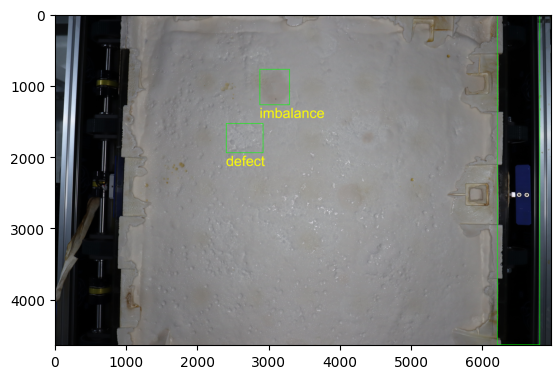

In [222]:
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

img_path = './dataset/1207_mycell/image/0322/A2303220026.JPG'
img = Image.open(img_path)#.convert('RGB')
#img.show()
print(img.size[0],img.size[1])
draw = ImageDraw.Draw(img)
date_dir = img_path.split('.JPG')[0].split('/')[-2]
file_name = img_path.split('.JPG')[0].split('/')[-1]
target_json = './dataset/1207_mycell/oringinal_json/23'+date_dir+'.json'
#     print(target_json,file_name)

assert os.path.isfile(target_json)
with open(target_json,'r') as f:
    json_data = json.load(f)
for l in json_data['frames']:
    json_file_name = l['name'].split('/')[-1].split('.JPG')[0]
    if json_file_name == file_name:
        for ll in l['labels']:
            try:
                class_index = str(categories[ll['category']])
                x1 = ll['box2d']['x1']
                x2 = ll['box2d']['x2']
                y1 = ll['box2d']['y1']
                y2 = ll['box2d']['y2']
                print(ll['id'],x1,x2,y1,y2,categories_list[int(class_index)])
                if x2 < x1:
                    draw.rectangle((x2,y2,x1,y1), outline=(0,255,0), width = 8)
                else: 
                    draw.rectangle((x1,y1,x2,y2), outline=(0,255,0), width = 8)
                try:
                    draw.text((x1,y2), categories_list[int(class_index)], (255,255,0), font=ImageFont.truetype("Arial", size=200))
                except IOError: 
                    print('no font')
            except: continue # 아마 val or test set에 있을 것
#img.show()
plt.imshow(img)
plt.show()


In [219]:
def covertTxtValues(label_txt):
    tt = []
    with open(label_txt,'r') as f:
        for line in f: 
#             print(line.strip())
#             print(line.strip().split(' '))
            ttt = []
            for t in line.strip().split(' '): ttt.append(float(t))
            tt.append(ttt)
    
    return tt

In [220]:
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

img_path = './yolov7/data/test/images/A2303220026_JPG.rf.87d103a38e4d2d08fab2270b1cfe6197.jpg'

img = Image.open(img_path)#.convert('RGB')
#img.show()
print(img.size[0],img.size[1])
draw = ImageDraw.Draw(img)
# date_dir = img_path.split('.jpg')[0].split('/')[-2]
file_name = img_path.split('.jpg')[0].split('/')[-1]
target_label_file = './yolov7/data/test/labels/'+file_name+'.txt'

assert os.path.isfile(target_json)

l = covertTxtValues(target_label_file)

print(l)
for ll in l:
    x1 = ll[1]
    x2 = ll[2]
    y1 = ll
# for l in json_data['frames']:
#     json_file_name = l['name'].split('/')[-1].split('.JPG')[0]
#     if json_file_name == file_name:
#         for ll in l['labels']:
#             try:
#                 class_index = str(categories[ll['category']])
#                 x1 = ll['box2d']['x1']
#                 x2 = ll['box2d']['x2']
#                 y1 = ll['box2d']['y1']
#                 y2 = ll['box2d']['y2']
#                 print(ll['id'],x1,x2,y1,y2,categories_list[int(class_index)])
#                 if x2 < x1:
#                     draw.rectangle((x2,y2,x1,y1), outline=(0,255,0), width = 8)
#                 else: 
#                     draw.rectangle((x1,y1,x2,y2), outline=(0,255,0), width = 8)
#                 try:
#                     draw.text((x1,y2), categories_list[int(class_index)], (255,255,0), font=ImageFont.truetype("Arial", size=200))
#                 except IOError: 
#                     print('no font')
#             except: continue # 아마 val or test set에 있을 것
# #img.show()
# plt.imshow(img)
# plt.show()


640 640
[[0.0, 0.9328125, 0.5, 0.08671875, 1.0], [1.0, 0.24140625, 0.47890625, 0.0515625, 0.06484375], [1.0, 0.1828125, 0.51640625, 0.00859375, 0.0125], [1.0, 0.38203125, 0.375, 0.075, 0.08984375], [1.0, 0.346875, 0.2203125, 0.02890625, 0.0296875], [1.0, 0.79296875, 0.12890625, 0.0125, 0.01484375], [1.0, 0.2609375, 0.72265625, 0.0171875, 0.0546875], [1.0, 0.22578125, 0.8328125, 0.03671875, 0.02734375], [1.0, 0.2140625, 0.8765625, 0.01328125, 0.025], [1.0, 0.2453125, 0.87421875, 0.0171875, 0.02890625], [1.0, 0.3078125, 0.76484375, 0.02109375, 0.04765625], [1.0, 0.32421875, 0.8609375, 0.0140625, 0.0390625], [1.0, 0.37265625, 0.85, 0.0125, 0.02265625], [1.0, 0.31328125, 0.6421875, 0.02578125, 0.06015625], [1.0, 0.2421875, 0.2890625, 0.053125, 0.14140625], [1.0, 0.31796875, 0.53359375, 0.02109375, 0.025], [1.0, 0.21015625, 0.53359375, 0.01484375, 0.0171875], [1.0, 0.2921875, 0.4296875, 0.01640625, 0.02734375], [1.0, 0.3109375, 0.27734375, 0.01953125, 0.0171875], [1.0, 0.34609375, 0.1265625

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

img_path = './data/test/images/A2303220026_JPG.rf.80869115b2c439a540e1fbcf3d05ca83.jpg'
img = Image.open(img_path)#.convert('RGB')
#img.show()
print(img.size[0],img.size[1])
draw = ImageDraw.Draw(img)
date_dir = img_path.split('.JPG')[0].split('/')[-2]
file_name = img_path.split('.JPG')[0].split('/')[-1]
target_json = './runs/detect/exp74/labels/A2303220026_JPG.rf.51effd93eca07b98830415b30212b973.txt'
#     print(target_json,file_name)

assert os.path.isfile(target_json)
with open(target_json,'r') as f:
    json_data = json.load(f)
for l in json_data['frames']:
    json_file_name = l['name'].split('/')[-1].split('.JPG')[0]
    if json_file_name == file_name:
        for ll in l['labels']:
            try:
                class_index = str(categories[ll['category']])
                x1 = ll['box2d']['x1']
                x2 = ll['box2d']['x2']
                y1 = ll['box2d']['y1']
                y2 = ll['box2d']['y2']
                print(ll['id'],x1,x2,y1,y2,categories_list[int(class_index)])
                if x2 < x1:
                    draw.rectangle((x2,y2,x1,y1), outline=(0,255,0), width = 8)
                else: 
                    draw.rectangle((x1,y1,x2,y2), outline=(0,255,0), width = 8)
                try:
                    draw.text((x1,y2), categories_list[int(class_index)], (255,255,0), font=ImageFont.truetype("Arial", size=200))
                except IOError: 
                    print('no font')
            except: continue # 아마 val or test set에 있을 것
#img.show()
plt.imshow(img)
plt.show()
